In [1]:
import FC2_train_v2 as FC2_MPO_Net
from neural_networks import *

# Pre-processing

## 1. Train multiple models

In [2]:
D = 8

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
all_weights = []
for bond_dim in range(2, D+1):
    print(bond_dim)
    weights = FC2_MPO_Net.main(r_1=bond_dim, r_2=bond_dim)
    all_weights.append(weights)

2
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.144
Accuracy at step 1: 0.1698
Accuracy at step 3: 0.2489
Accuracy at step 4: 0.2581
Accuracy at step 6: 0.2944
Accuracy at step 7: 0.3856
Accuracy at step 15: 0.4005
Accuracy at step 16: 0.4156
Accuracy at step 17: 0.4805
Acc

## 2. Convert weights tensors into model class

In [1]:
class Model:
    def __init__(self, weights, bond_dim):
        self.weights = weights
        self.MPO_0, self.bias_0 = weights_to_MPO(weights, bond_dim, sigma=[4, 7, 7, 4], sigma_prime=[4, 4, 4, 4], layer=0)
        self.MPO_1, self.bias_1 = weights_to_MPO(weights, bond_dim, sigma=[4, 4, 4, 4], sigma_prime=[1, 10, 1, 1], layer=1)
        self.MPS_0 = close_legs(self.MPO_0)
        self.MPS_1 = close_legs(self.MPO_1)

        self.compressed_MPS_0, _, _ = compress_layer(self.MPS_0, phys_dim=[16, 28, 28, 16], threshold=1e-8, plot=0)
        self.compressed_MPS_0.append(self.MPS_0)
        self.compressed_MPS_1, _, _ = compress_layer(self.MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-8, plot=0)
        self.compressed_MPS_1.append(self.MPS_1)

        self.acc_matrix = []
        self.compression_matrix = []
        self.best_W0 = []
        self.best_W1 = []

In [5]:
all_models = []
for i in range(2, D+1):
    all_models.append(Model(all_weights[i-2], bond_dim=i))

Sim: 0.3222087293593474 Dist: 26.834398932100463 BondDim: 1
Sim: 0.3126844135668347 Dist: 8.00292503163209 BondDim: 1
Sim: 0.14887065224861695 Dist: 29.66149108526943 BondDim: 1
Sim: 0.47216213121160416 Dist: 23.3585278758432 BondDim: 2
Sim: 0.27833119275012386 Dist: 6.304340554295693 BondDim: 1
Sim: 0.8240606809275501 Dist: 3.112806693076502 BondDim: 2
Sim: 0.13688745669549193 Dist: 61.46430232021424 BondDim: 1
Sim: 0.4098362962434973 Dist: 50.82477799240299 BondDim: 2
Sim: 0.7279204851793751 Dist: 34.50938061488357 BondDim: 3
Sim: 0.19767059017583657 Dist: 6.0011738514911395 BondDim: 1
Sim: 0.5092673206411191 Dist: 4.693343516049779 BondDim: 2
Sim: 0.8237012140848845 Dist: 2.8130957405788903 BondDim: 3
Sim: 0.07687712993995936 Dist: 50.56718955092473 BondDim: 1
Sim: 0.3617820447202432 Dist: 42.04589202386978 BondDim: 2
Sim: 0.6261323350491754 Dist: 32.18088729406807 BondDim: 3
Sim: 0.8247809097068214 Dist: 22.030774853687742 BondDim: 4
Sim: 0.18657648505854227 Dist: 6.75164802076827 

## 3. Check model accuracies

In [6]:
for model in all_models:
    acc, t = FC2(model.MPO_0, model.bias_0, model.MPO_1, model.bias_1)
    print(acc, "%", t, "s")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
85.53 % 0.0010085105895996094 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
85.91 % 0.0029916763305664062 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.47 % 0.002992391586303711 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
92.69 % 0.003988742828369141 s
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-label

## 4. Check model parameters

In [11]:
for model in all_models:
    orig = calculate_params(model.MPS_0) + calculate_params(model.MPS_1)
    print("Orig:", orig)
    for i in range(len(model.compressed_MPS_0)):
        compressed = calculate_params(model.compressed_MPS_0[i]) + calculate_params(model.compressed_MPS_1[i])
        print(i+1, compressed)

Orig: 480
1 140
2 480
Orig: 1020
1 140
2 480
3 1020
Orig: 1760
1 140
2 480
3 1020
4 1760
Orig: 2700
1 140
2 480
3 1020
4 1760
5 2700
Orig: 3840
1 140
2 480
3 1020
4 1760
5 2472
6 3840
Orig: 5180
1 140
2 480
3 1020
4 1760
5 2472
6 3296
7 5180
Orig: 6720
1 140
2 480
3 1020
4 1760
5 2472
6 3296
7 4232
8 6720


# Accuracy Tests

## 1. Calculate overall best accuracy for normalizing loss

In [8]:
best_acc, _ = FC2(all_models[-1].MPO_0, all_models[-1].bias_0, all_models[-1].MPO_1, all_models[-1].bias_1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


## 2. Loss vs. Compressed Dimension for first layer

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

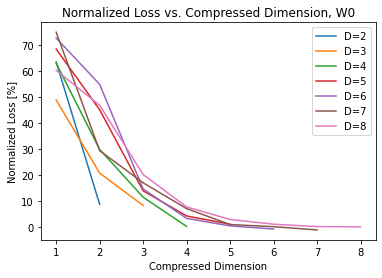

In [9]:
plt.figure()
plt.xlabel('Compressed Dimension')
plt.ylabel('Normalized Loss [%]')
plt.title('Normalized Loss vs. Compressed Dimension, W0')

for model in all_models:
    ### Maximizing total accuracy
    acc_compressed = []
    time_compressed = []
    params = []

    for i in range(len(model.compressed_MPS_0)):
        MPS_0_test = model.compressed_MPS_0[i]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = model.MPO_1

        total_params = 0
        for tensor in MPO_0_test:
            total_params += tensor.size
        for tensor in MPO_1_test:
            total_params += tensor.size
        params.append(total_params)

        acc, t = FC2(MPO_0_test, model.bias_0, MPO_1_test, model.bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in model.MPO_0:
        params_orig += tensor.size
    for tensor in model.MPO_1:
        params_orig += tensor.size

    params = np.array(params)/params_orig*100
    acc_orig, time_orig = FC2(model.MPO_0, model.bias_0, model.MPO_1, model.bias_1)


    x = range(1, len(model.compressed_MPS_0)+1)
    data1 = acc
    data2 = params

    normalized_loss = [(1-x/best_acc)*100 for x in acc_compressed]
 
    plt.plot(x, normalized_loss, label="D=%d" % (len(model.compressed_MPS_0)))

plt.legend()

## 3. Loss vs. Compressed Dimension for second layer

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

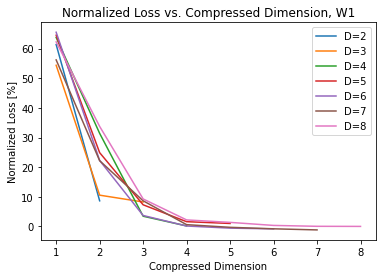

In [10]:
plt.figure()
plt.xlabel('Compressed Dimension')
plt.ylabel('Normalized Loss [%]')
plt.title('Normalized Loss vs. Compressed Dimension, W1')

for model in all_models:
    ### Maximizing total accuracy
    acc_compressed = []
    time_compressed = []
    params = []

    for i in range(len(model.compressed_MPS_1)):
        MPS_1_test = model.compressed_MPS_1[i]

        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = model.MPO_0
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

        total_params = 0
        for tensor in MPO_0_test:
            total_params += tensor.size
        for tensor in MPO_1_test:
            total_params += tensor.size
        params.append(total_params)

        acc, t = FC2(MPO_0_test, model.bias_0, MPO_1_test, model.bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in model.MPO_0:
        params_orig += tensor.size
    for tensor in model.MPO_1:
        params_orig += tensor.size

    params = np.array(params)/params_orig*100
    acc_orig, time_orig = FC2(model.MPO_0, model.bias_0, model.MPO_1, model.bias_1)


    x = range(1, len(model.compressed_MPS_0)+1)
    data1 = acc
    data2 = params

    normalized_loss = [(1-x/best_acc)*100 for x in acc_compressed]

    plt.plot(x, normalized_loss, label="D=%d" % (len(model.compressed_MPS_0)))

plt.legend()